# Viés e imparcialidade no aprendizado de máquina
Parte 1: apresentando nosso conjunto de dados e o problema

Geralmente, o objetivo declarado de um problema de aprendizado de máquina é criar um pipeline de engenharia de recursos que maximize o desempenho de um modelo em um conjunto de dados. Nosso objetivo nesta série de artigos, no entanto, será não apenas monitorar e medir o desempenho do modelo, mas também acompanhar como nosso modelo trata diferentes grupos de dados porque, às vezes, os dados são pessoas .

Em nosso estudo de caso de hoje, os dados são pessoas cujas vidas estão em risco. Os dados são pessoas que simplesmente querem ter a melhor vida possível. Enquanto navegamos em torno de preconceito e discriminação, privilégio sistêmico e discrepâncias raciais, pedimos que você tenha em mente que, quando falamos de linhas, estamos falando de pessoas e, quando falamos de características, estamos falando de agregar anos se não décadas de experiências de vida em um único número, classe ou booleano . Devemos respeitar nossos dados e as pessoas que nossos dados representam.

Vamos começar.

# O conjunto de dados COMPAS

O conjunto de dados para este estudo de caso é o conjunto de dados Correctional Offender Management Profiling for Alternative Sanctions (COMPAS), que é uma coleção de criminosos rastreados no Condado de Broward, Flórida, nos anos de 2013–2014.
Em particular, estamos analisando um subconjunto desses dados que corresponde a um problema de classificação binária de previsão de reincidência (se uma pessoa reincidirá ou não) dadas certas características sobre um indivíduo.
Um link para o conjunto de dados pode ser encontrado aqui:
https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv

À primeira vista, o problema é bastante simples. Classificação binária, sem dados perdidos, vamos lá! O problema surge quando nossos modelos de ML têm efeitos contrários muito reais na vida e no bem-estar das pessoas. Como engenheiros de ML e cientistas de dados, grande parte dessa carga recai sobre nós para criar modelos que não apenas apresentem bom desempenho, mas também gerem previsões que possam ser consideradas “justas”.

À medida que avançamos nesta aula, definiremos e quantificaremos “justo” de várias maneiras e, finalmente, uma decisão deve ser tomada sobre qual critério de imparcialidade é melhor para um determinado domínio de problema. Nosso objetivo nesta aula será apresentar várias definições de justiça e dar exemplos de como cada uma deve ser interpretada.

**Isenção de responsabilidade**:  este estudo de caso não representa um estudo estatístico nem deve ser usado para fazer generalizações sobre o sistema de justiça criminal dos Estados Unidos. Nosso objetivo é destacar instâncias de viés nos dados e promover ferramentas para maximizar a justiça em nossos sistemas de ML.

Vamos começar carregando nossos dados e dando uma olhada.

In [4]:
import pandas as pd
import numpy as np

compas_df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')
compas_df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


As primeiras cinco linhas de nosso conjunto de dados COMPAS mostram algumas informações confidenciais sobre pessoas que foram encarceradas no Condado de Broward, Flórida. Nosso rótulo de resposta aqui é “two_year_recid”, que representa uma resposta à pergunta binária “essa pessoa voltou ao encarceramento dentro de 2 anos após ser libertada?”

No estudo original da ProPublica de 2016, que analisou a imparcialidade do algoritmo COMPAS, software e dados subjacentes, eles se concentraram na pontuação do decil dado a cada pessoa. Uma pontuação decil é uma pontuação de 1 a 10 que dimensiona os dados em intervalos de 10%. Se essa palavra parece um tanto familiar, é porque está intimamente relacionada à ideia de percentil. A ideia é que uma pessoa possa receber uma pontuação entre 1 e 10, onde cada pontuação representa uma parte de uma população na qual uma certa porcentagem de pessoas acima e abaixo tem uma classificação mais alta em uma métrica. Por exemplo, se dermos a alguém uma pontuação decil de 3, isso significa que 70% das pessoas devem ter um risco maior de reincidência (pessoas com pontuações de 4, 5, 6, 7, 8, 9 e 10) e 20% das pessoas têm menor risco de reincidência (pessoas com pontuações de 1 e 2). Da mesma forma, uma pontuação de 7 significa que 30% das pessoas têm uma taxa de reincidência mais alta (pessoas com pontuação de 8, 9, 10), enquanto 60% das pessoas têm uma taxa de reincidência menor (pessoas com pontuação de 1, 2, 3 , 4, 5,

O estudo foi além ao mostrar as disparidades entre como as pontuações em decis são usadas e como elas nem sempre parecem justas. Por exemplo, se observarmos como as pontuações são distribuídas, podemos ver que as pontuações são dadas de forma diferente por raça. O trecho a seguir traçará um histograma de pontuações de decis por raça e destaca algumas coisas:


1.   As pontuações dos decis dos afro-americanos estão distribuídas de maneira relativamente uniforme, com cerca de 10% da população residindo em cada pontuação do decil. Por definição de uma pontuação decil, isso é apropriado. 10% da população deveria, em teoria, viver em cada pontuação decil;
2.   As categorias Asiática, Caucasiana, Hispânica e Outras parecem ter uma inclinação certa nas pontuações decil, com uma porção maior do que o esperado da categoria tendo uma pontuação decil de 1 ou 2.

<Axes: title={'center': 'Histograma de escore decil por raça'}, ylabel='% com escore decil'>

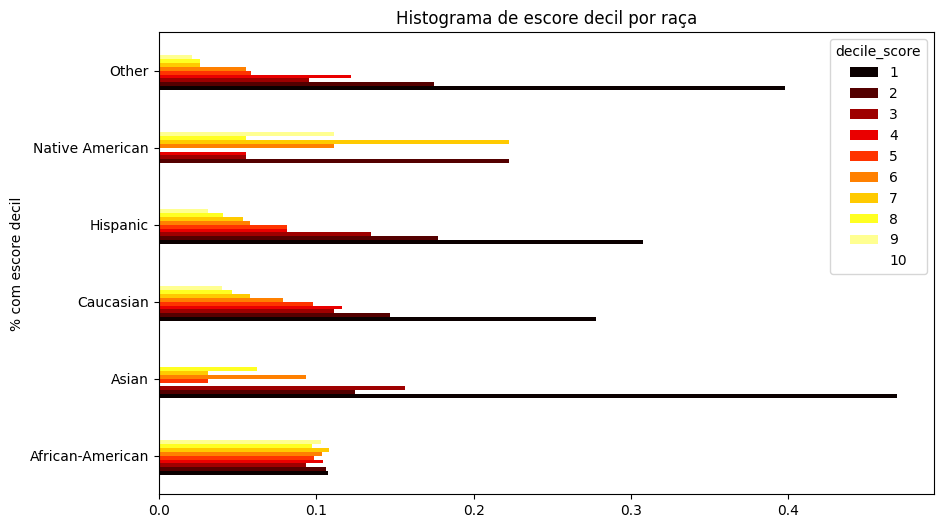

In [5]:
compas_df.groupby('race')['decile_score'].value_counts(
     normalize=True
 ).unstack().plot(
     kind='barh', figsize=(10, 6), colormap='hot',
     title='Histograma de escore decil por raça', ylabel='% com escore decil'
 )

Podemos ver diferenças claras em como as pontuações por decil são distribuídas quando divididas por raça.

In [6]:
compas_df.groupby('race')['decile_score'].value_counts(normalize=True)

race              decile_score
African-American  7               0.108225
                  1               0.107684
                  2               0.106331
                  4               0.104167
                  6               0.103896
                  9               0.102814
                  5               0.098755
                  8               0.097132
                  3               0.093615
                  10              0.077381
Asian             1               0.468750
                  3               0.156250
                  2               0.125000
                  6               0.093750
                  8               0.062500
                  5               0.031250
                  7               0.031250
                  10              0.031250
Caucasian         1               0.277506
                  2               0.147107
                  4               0.116137
                  3               0.111247
                  5               0.098207
                  6               0.079055
                  7               0.058272
                  8               0.046455
                  9               0.039935
                  10              0.026080
Hispanic          1               0.307692
                  2               0.177394
                  3               0.135008
                  4               0.081633
                  5               0.081633
                  6               0.058085
                  7               0.053375
                  8               0.040816
                  10              0.032967
                  9               0.031397
Native American   2               0.222222
                  7               0.222222
                  10              0.166667
                  6               0.111111
                  9               0.111111
                  3               0.055556
                  4               0.055556
                  8               0.055556
Other             1               0.397878
                  2               0.175066
                  4               0.122016
                  3               0.095491
                  5               0.058355
                  6               0.055703
                  7               0.026525
                  8               0.026525
                  9               0.021220
                  10              0.021220
Name: proportion, dtype: float64

In [7]:
# Os tribunais geralmente usam uma pontuação de decil 5 para rotular alguém como sendo de risco médio.
compas_df['is_med_or_high_risk'] = (compas_df['decile_score']>=5).astype(bool)

In [8]:
# Não é ótimo se o sistema do tribunal retorna 5 ou mais na pontuação do decil preciso apenas 65% das vezes
(compas_df['is_med_or_high_risk']==compas_df['two_year_recid']).mean()

np.float64(0.6537288605489326)

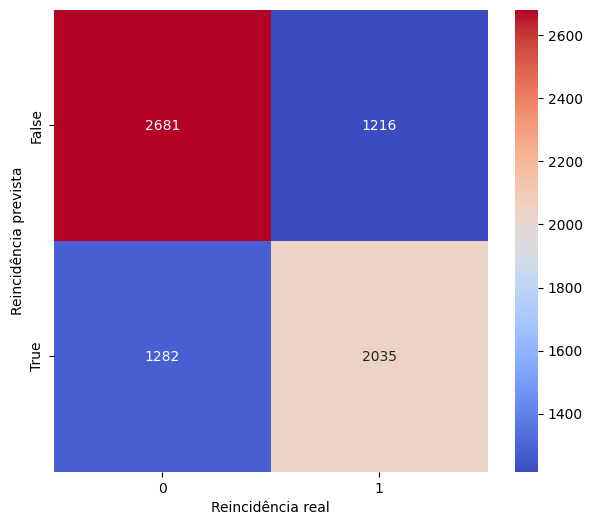

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# heatmap of recidivism
cm = pd.crosstab(
    compas_df['is_med_or_high_risk'], compas_df['two_year_recid'],
    rownames=['Reincidência prevista'], colnames=['Reincidência real']
)
p = plt.figure(figsize=(7,6))
p = sns.heatmap(cm, annot=True, cmap="coolwarm", fmt='d')

In [10]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
reincidencia_ = (
    pd.read_csv(url)
    [['age_cat', 'sex', 'race', 'decile_score', 'score_text', 'two_year_recid']]
    .loc[lambda x:x.race.isin(['African-American', 'Caucasian'])]
    .assign(COMPAS_Decision=lambda x:x['score_text'].replace({'Low': 0, 'Medium':1, 'High': 1}))
)

<ipython-input-10-549e24325635>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .assign(COMPAS_Decision=lambda x:x['score_text'].replace({'Low': 0, 'Medium':1, 'High': 1}))


O algoritmo COMPAS, no conjunto de dados como um todo, é relativamente equilibrado. Listamos algumas observações sobre as decisões dos algoritmos COMPAS, em média, para a população de estudo:

Metade dos réus previstos reincidiriam (e metade previu que não), o que é ligeiramente menor do que a proporção real de reincidentes.

35% da população experimentou uma decisão incorreta, aproximadamente equilibrada entre falsos positivos e falsos negativos.

A tabela abaixo resume essas estatísticas:

In [11]:
pd.crosstab(reincidencia_['COMPAS_Decision'], reincidencia_['two_year_recid'], normalize=True, margins=True)

two_year_recid,0,1,All
COMPAS_Decision,,,
0,0.346179,0.161463,0.507642
1,0.187642,0.304715,0.492358
All,0.533821,0.466179,1.000000


In [12]:
b_recid = reincidencia_[reincidencia_['race'] == 'African-American']
w_recid = reincidencia_[reincidencia_['race'] == 'Caucasian']

pd.concat([
    pd.crosstab(b_recid['COMPAS_Decision'], b_recid['two_year_recid'], normalize=True, margins=True),
    pd.crosstab(w_recid['COMPAS_Decision'], w_recid['two_year_recid'], normalize=True, margins=True)
], axis=1, keys=['Black', 'White'])

Black                         White                    
two_year_recid          0         1       All         0         1       All
COMPAS_Decision                                                            
0                0.267857  0.143939  0.411797  0.464140  0.187857  0.651997
1                0.217803  0.370400  0.588203  0.142217  0.205786  0.348003
All              0.485660  0.514340  1.000000  0.606357  0.393643  1.000000

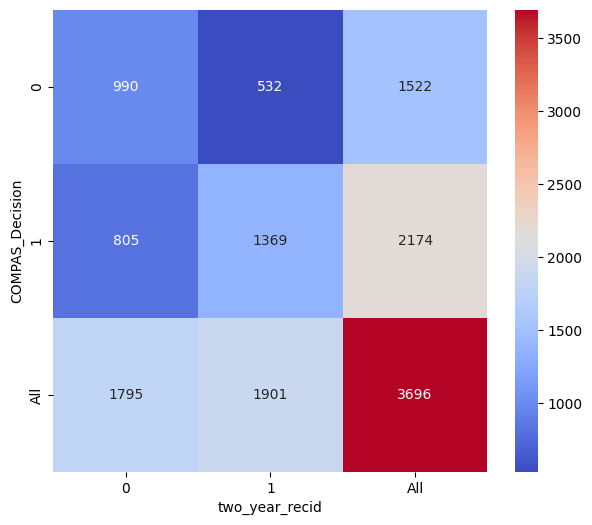

In [13]:
# heatmap of recidivism
afro_a = pd.crosstab(b_recid['COMPAS_Decision'], b_recid['two_year_recid'], normalize=False, margins=True)
p = plt.figure(figsize=(7,6))
p = sns.heatmap(afro_a, annot=True, cmap="coolwarm", fmt='d')

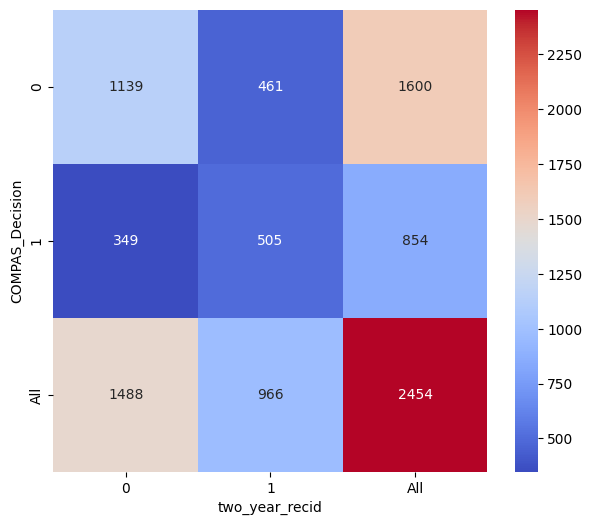

In [14]:
cauc_a = pd.crosstab(w_recid['COMPAS_Decision'], w_recid['two_year_recid'], normalize=False, margins=True)
p = plt.figure(figsize=(7,6))
p = sns.heatmap(cauc_a, annot=True, cmap="coolwarm", fmt='d')

In [15]:
from sklearn.metrics import confusion_matrix
confusao_cauc = confusion_matrix(y_true=w_recid['COMPAS_Decision'], y_pred=w_recid['two_year_recid'])

In [16]:
confusao_cauc

array([[1139,  461],
       [ 349,  505]])

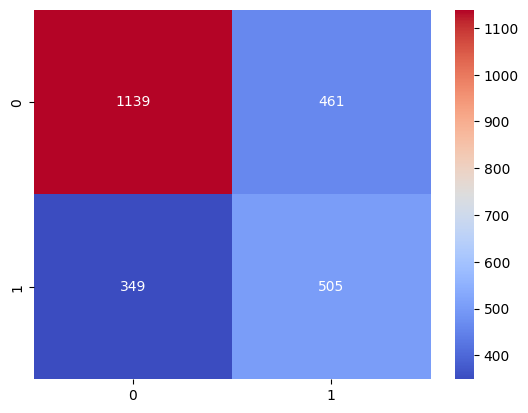

In [17]:
eixos_cauc = sns.heatmap(confusao_cauc, annot=True, cmap='coolwarm', fmt='d')

In [18]:
confusao_afro = confusion_matrix(y_true=b_recid['COMPAS_Decision'], y_pred=b_recid['two_year_recid'])

In [19]:
confusao_afro

array([[ 990,  532],
       [ 805, 1369]])

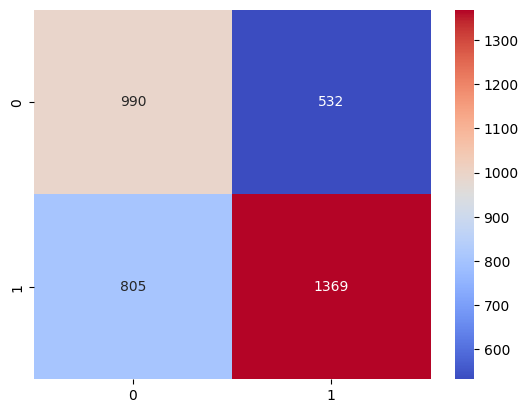

In [20]:
eixos_afro = sns.heatmap(confusao_afro, annot=True, cmap='coolwarm', fmt='d')

In [21]:
# importar classification_report para análise e métricas
from sklearn.metrics import classification_report

In [22]:
# utilizar classification_report aqui
print(classification_report(w_recid['COMPAS_Decision'], w_recid['two_year_recid']))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1600
           1       0.52      0.59      0.55       854

    accuracy                           0.67      2454
   macro avg       0.64      0.65      0.65      2454
weighted avg       0.68      0.67      0.67      2454



In [23]:
# utilizar classification_report aqui
print(classification_report(b_recid['COMPAS_Decision'], b_recid['two_year_recid']))

              precision    recall  f1-score   support

           0       0.55      0.65      0.60      1522
           1       0.72      0.63      0.67      2174

    accuracy                           0.64      3696
   macro avg       0.64      0.64      0.63      3696
weighted avg       0.65      0.64      0.64      3696



In [24]:
from sklearn import metrics

def calc_metrics(df):

    conf = metrics.confusion_matrix(df.two_year_recid, df.COMPAS_Decision)
    TP = conf[1,1]
    TN = conf[0,0]
    FP = conf[0,1]
    FN = conf[1,0]

    fnr = FN / (TP + FN)
    fpr = FP / (FP + TN)
    acc = (TP + TN) / (TP + TN + FP + FN)

    return pd.Series({'FNR': fnr, 'FPR': fpr, 'ACC': acc})

pd.concat([
    calc_metrics(reincidencia_).rename('ALL').to_frame().T,
    reincidencia_.groupby('race').apply(calc_metrics)
])

<ipython-input-24-c13e5318d598>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reincidencia_.groupby('race').apply(calc_metrics)


,FNR,FPR,ACC
ALL,0.346355,0.351508,0.650894
African-American,0.279853,0.448468,0.638258
Caucasian,0.477226,0.234543,0.669927


In [25]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
reincidencia_ = (
    pd.read_csv(url)
    .drop(['name', 'first', 'last'], axis=1)
    .assign(pred_recid_=lambda x:x['score_text'].isin(['Medium', 'High']).astype(int))
)

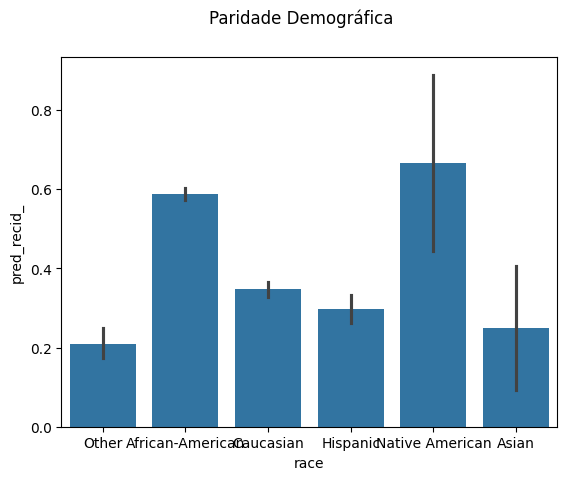

In [26]:
a = reincidencia_
sns.barplot(data=a, x='race', y='pred_recid_')
plt.suptitle('Paridade Demográfica');

Podemos ver isso mais claramente inspecionando algumas estatísticas básicas sobre pontuações de decis por raça:

In [27]:
compas_df.groupby('race')['decile_score'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,5.368777,2.831122,1.0,3.00,5.0,8.00,10.0
Asian,32.0,2.937500,2.601953,1.0,1.00,2.0,3.50,10.0
Caucasian,2454.0,3.735126,2.597926,1.0,1.00,3.0,5.00,10.0
Hispanic,637.0,3.463108,2.599100,1.0,1.00,3.0,5.00,10.0
Native American,18.0,6.166667,2.975389,2.0,3.25,7.0,8.75,10.0
Other,377.0,2.949602,2.350895,1.0,1.00,2.0,4.00,10.0


Observando as médias e medianas das pontuações em decil por raça, podemos ver, por exemplo, que a pontuação média em decil para afro-americanos é 5 (o que é esperado), mas para caucasianos e hispânicos é 3.

Poderíamos continuar analisando como o estudo ProPublica interpretou esses dados, mas, em vez de tentar recriar esses resultados, nossa abordagem para esse conjunto de dados será focada na construção de um classificador binário com os dados, ignorando a pontuação do decil já dada às pessoas.

# A Declaração do Problema

Conforme mencionado na seção anterior, o problema de ML aqui é de classificação binária. O objetivo do nosso modelo pode ser resumido pela pergunta:

*“Dados certos aspectos sobre uma pessoa, podemos prever a reincidência de forma precisa e justa?”*

O termo com precisão deve ser fácil o suficiente. Temos muitas métricas para medir o desempenho do modelo, incluindo exatidão (acurácia), precisão e AUC. No entanto, quando se trata do termo “fairly”, precisaremos aprender alguns novos termos e métricas. Antes de entrarmos em como quantificar o viés e a imparcialidade, vamos primeiro fazer um pouco de EDA sabendo do problema em questão.

# Análise exploratória de dados

Nosso objetivo é modelar diretamente nosso rótulo de resposta two_year_recidcom base nos recursos sobre as pessoas neste conjunto de dados. Especificamente, temos as seguintes características:

1. sex – qualitativo, binário “masculino” ou “feminino”;
2. age – relação quantitativa, em anos;
3. race – nominal qualitativo;
4. juv_fel_count – quantitativo, o número de delitos graves (crimes) juvenis anteriores que essa pessoa cometeu;
5. juv_misd_count – quantitativo, o número de delitos leves (contravenções) juvenis anteriores que essa pessoa cometeu;
6. juv_other_count – quantitativo, o número v de condenações juvenis que não são crime nem contravenção;
7. priors_count – quantitativo, o número de crimes anteriores cometidos;
8. c_charge_degree – qualitativo, binário, 'F' para crime e 'M' para contravenção.


E nosso rótulo de resposta:

1. two_year_recid – qualitativo, binário, esta pessoa reincidiu (cometeu outro crime) dentro de 2 anos, sim ou não.

Observe que temos três colunas separadas para contar delitos juvenis. Devemos observar que, para nossos modelos, podemos querer combiná-los em uma única coluna que simplesmente conte o número de delitos juvenis que essa pessoa cometeu.

Dada a nossa declaração do problema de criar um modelo preciso e justo, vejamos a repartição da reincidência por raça. Quando agrupamos nosso conjunto de dados por raça e observamos a taxa de reincidência, fica claro que existem diferenças nas “taxas básicas” de reincidência. Sem detalhar mais (por idade, antecedentes criminais etc.), existem grandes diferenças nas taxas de reincidência entre diferentes categorias raciais.

In [28]:
compas_df.groupby('race')['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,0.514340,0.499862,0.0,0.0,1.0,1.0,1.0
Asian,32.0,0.281250,0.456803,0.0,0.0,0.0,1.0,1.0
Caucasian,2454.0,0.393643,0.488657,0.0,0.0,0.0,1.0,1.0
Hispanic,637.0,0.364207,0.481585,0.0,0.0,0.0,1.0,1.0
Native American,18.0,0.555556,0.511310,0.0,0.0,1.0,1.0,1.0
Other,377.0,0.352785,0.478472,0.0,0.0,0.0,1.0,1.0


Estatísticas descritivas de reincidência por raça vistas acima. Podemos ver uma clara diferença nas taxas de reincidência entre nossos diferentes grupos raciais

Também devemos observar que temos duas categorias de raça (asiáticas e nativas americanas) com representação extremamente pequena em nossos dados. Este é um exemplo de **viés de amostra** em que a população pode não ser representada adequadamente. Esses dados são retirados do Condado de Broward, Flórida, onde – de acordo com o censo dos EUA – aqueles que se identificam como asiáticos, por exemplo, constituem cerca de 4% da população; enquanto no conjunto de dados, eles representam cerca de 0,44% dos dados.

Para nossos propósitos nesta aula, rotularemos novamente os pontos de dados com raça como “asiáticos” ou “nativos americanos” e renomearemos sua raça como “outro” para evitar qualquer equívoco em nossas métricas em relação a ter duas categorias de raça sendo tão sub-representada. Nosso principal motivo para fazer essa nova rotulagem é tornar as classes resultantes mais equilibradas. Em nossa última figura, fica claro que as contagens de pessoas nas classes “asiáticas” e “nativas americanas” estão muito sub-representadas e, portanto, seria inapropriado tentar usar esse conjunto de dados para fazer previsões significativas sobre elas.

Depois de rotular novamente esses pontos de dados, vamos plotar as taxas reais de reincidência de 2 anos para nossas agora quatro categorias de raça consideradas.

In [29]:
# Renomear duas raças como Other.
# Apenas por razões educacionais e para evitar problemas com amostras distorcidas
compas_df.loc[compas_df['race'].isin(['Native American', 'Asian']), 'race'] = 'Other'

In [30]:
compas_df.groupby('race')['two_year_recid'].value_counts(normalize=True)

race              two_year_recid
African-American  1                 0.514340
                  0                 0.485660
Caucasian         0                 0.606357
                  1                 0.393643
Hispanic          0                 0.635793
                  1                 0.364207
Other             0                 0.644028
                  1                 0.355972
Name: proportion, dtype: float64

<Axes: title={'center': 'Taxas reais de reincidência por raça'}, ylabel='race'>

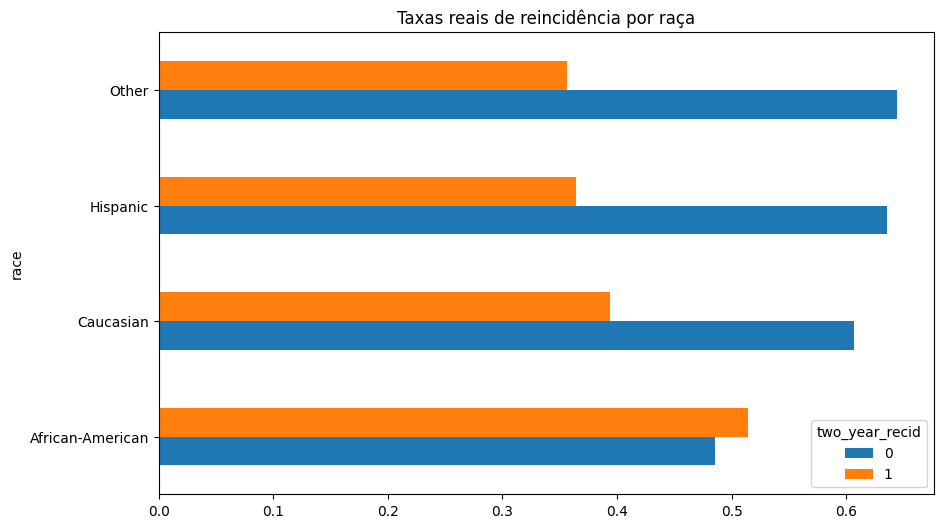

In [31]:
# Plotar taxas de reincidência
compas_df.groupby('race')['two_year_recid'].value_counts(normalize=True).unstack().plot(
     kind='barh', figsize=(10, 6), title='Taxas reais de reincidência por raça')

Mais uma vez, podemos ver que nossos dados mostram que os afro-americanos reincidem a uma taxa mais alta do que os caucasianos, hispânicos ou outros. A razão disso é o resultado de muitas razões sistêmicas diferentes que não podemos nem começar a abordar nesta aula. Por enquanto, observemos que, embora as taxas de reincidência sejam diferentes entre os grupos, a diferença entre uma divisão próxima de 50/50 para afro-americanos e a divisão de 60/40 para caucasianos não são taxas radicalmente diferentes.

**Disparidades em gênero**:  Também poderíamos ter escolhido observar o viés em "Sex", pois há definitivamente disparidades entre aqueles identificados como homens e mulheres neste conjunto de dados. Para os propósitos deste estudo de caso, optamos por focar nos vieses raciais presentes nos dados.

Vamos continuar examinando nossos outros atributos um pouco mais. Temos um atributo binário que teremos que codificar como um booleano, mas parece utilizável em sua forma atual:

<Axes: title={'center': '% grau do crime'}, xlabel='Grau do crime', ylabel='%'>

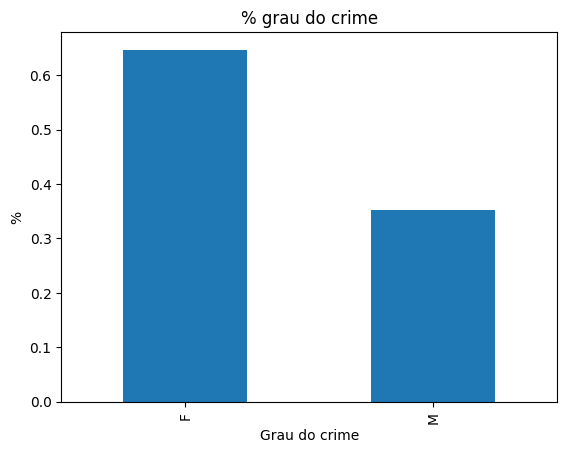

In [32]:
compas_df['c_charge_degree'].value_counts(normalize=True).plot(
     kind='bar', title='% grau do crime', ylabel='%', xlabel='Grau do crime')

Observa-se no gráfico acima a distribuição de crimes e contravenções em nosso conjunto de dados por grau. Temos cerca de 65% de nossas acusações como F por crimes e o restante como M por contravenções.

Vamos encerrar nosso EDA observando um histograma de nossos atributos quantitativos restantes: age e priors_count. Ambas as variáveis ​​estão mostrando uma inclinação direita bastante clara e seria benéfico realizar alguma padronização para lidar um pouco com esses valores discrepantes.

<Axes: title={'center': 'Histograma de crimes anteriores'}, xlabel='Prévios', ylabel='Frequency'>

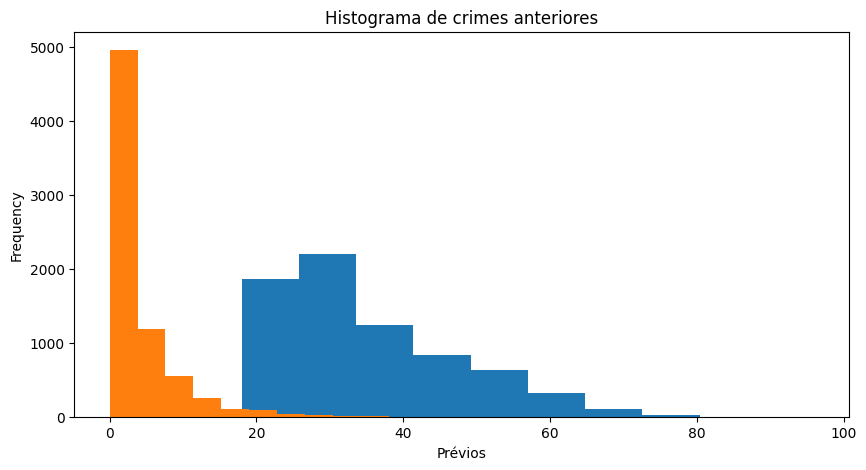

In [33]:
# Inclinação à direita em Age
compas_df['age'].plot(title='Histograma de idade', kind='hist', xlabel='Idade', figsize=(10, 5))

# Inclinação à direita em Priors
compas_df['priors_count'].plot(title='Histograma de crimes anteriores', kind='hist', xlabel='Prévios', figsize=(10, 5))

<Axes: title={'center': 'Histograma de crimes anteriores'}, xlabel='Prévios', ylabel='Frequency'>

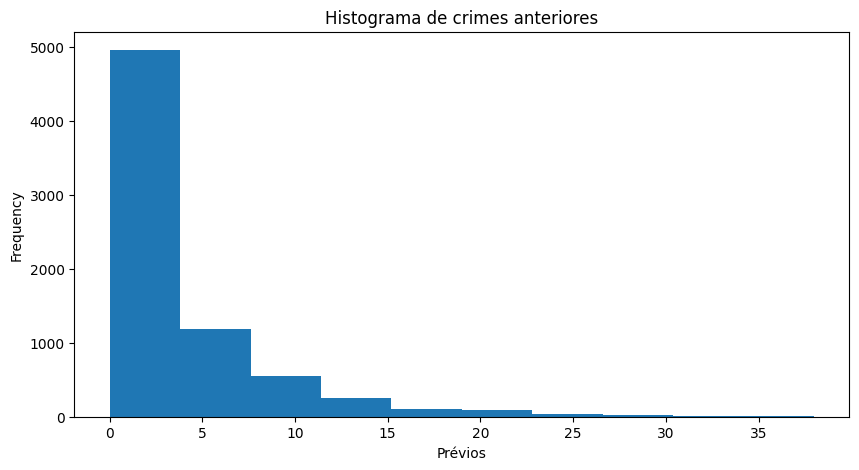

In [34]:
# Inclinação à direita em Priors
compas_df['priors_count'].plot(title='Histograma de crimes anteriores', kind='hist', xlabel='Prévios', figsize=(10, 5))

A contagem de idade e antecedentes mostra uma inclinação à direita nos dados. Está mostrando que a maioria das pessoas em nosso conjunto de dados está no lado jovem, mas temos alguns valores discrepantes puxando a média para a direita. Isso surgirá novamente quando investigarmos a imparcialidade do modelo.

Com nosso EDA nos dando uma visão inicial, vamos discutir e medir o viés e a imparcialidade de nossos modelos.

# Medindo o viés e a imparcialidade

Quando encarregados de tornar as previsões de modelo justas e imparciais, precisamos examinar algumas maneiras diferentes de formular e quantificar a imparcialidade para que possamos quantificar o desempenho de nossos modelos de ML.

# Tratamento Díspar vs Impacto Díspar

Em geral, um modelo – ou realmente qualquer processo preditivo/de tomada de decisão – pode sofrer de duas formas de viés: Tratamento Díspar (Disparate Treatment) e Impacto Díspar (Disparate Impact). Considera-se que um modelo sofre de Tratamento Díspar se as previsões forem de alguma forma baseadas em um atributo sensível (como gênero ou raça). Um modelo também pode ter um impacto díspar se as previsões/resultados das previsões prejudicarem ou beneficiarem desproporcionalmente pessoas com características sensíveis específicas que podem parecer prever taxas mais altas de reincidência para uma raça em relação a outra.

# Definições de Justiça (*Fairness*)

Existem pelo menos dezenas de maneiras de definir justiça em um modelo, mas vamos nos concentrar em três por enquanto e, quando estivermos construindo nosso modelo básico, as veremos novamente e mais delas.

# Desconhecimento/Inconsciência (*Unawareness*)

Desconhecimento/Inconsciência é provavelmente a definição mais fácil de justiça. Ele afirma que um modelo não deve incluir atributos confidenciais como um atributo nos dados de treinamento. Dessa forma, nosso modelo não terá acesso aos valores sensíveis ao treinar. Essa definição se alinha bem com a ideia de tratamento díspar, pois literalmente não estamos permitindo que o modelo veja os valores confidenciais de nossos dados.

A vantagem superficial de usar inconsciência como definição é que é muito fácil explicar a alguém que simplesmente não usamos um atributo em nosso modelo, portanto, como ele poderia ter obtido algum viés? O contra-argumento a esta afirmação e a principal falha de confiar na inconsciência para definir justiça é que, na maioria das vezes, o modelo será capaz de reconstruir valores sensíveis confiando em outros atributos altamente correlacionados com o atributo sensível original que estávamos tentando ignorar.

Por exemplo, se um recrutador está decidindo se deve ou não contratar um candidato e desejamos que ele seja sensível ao sexo do candidato, podemos simplesmente ocultara do recrutador o sexo do candidato; no entanto, se o recrutador também perceber que o candidato listou “fraternidades” como uma experiência anterior de voluntariado/liderança, o recrutador pode concluir razoavelmente que o candidato provavelmente é um homem.

# Paridade Estatística

A paridade estatística, também conhecida como paridade demográfica ou impacto díspar, é uma definição muito comum de justiça. Simplificando, ele afirma que a previsão do nosso modelo de estar em uma determinada classe (eles vão reincidir ou não) é independente do atributo sensível. Coloque como fórmula:

P(reincidência | raça=afro-americana) = P(reincidência | raça=caucasiana) = P(reincidência | raça=hispânica) = P(reincidência | raça=outro)

Em outras palavras, para obter uma boa paridade estatística, nosso modelo deve prever taxas iguais de reincidência para todas as categorias raciais. A fórmula acima é bastante rígida e, para relaxar, podemos nos apoiar na regra dos quatro quintos, que afirma que uma taxa de seleção (a taxa na qual prevemos a reincidência) para qualquer grupo desfavorecido, a proporção de nossas taxas de predição pode cair no faixa (0,8; 1/0,8) e ser considerado justa. Como uma fórmula, isso se parece com o seguinte.

0,8 < P(reincidência | raça=desfavorecido) / P(reincidência | raça=privilegiado) < 1/,8 (1,25)

As vantagens de usar a paridade estatística como uma definição de justiça é que é relativamente fácil explicar a métrica. Também há evidências de que usar Paridade Estatística como uma definição pode levar a benefícios de curto e longo prazo dos grupos desvantajosos: [A Short-term Intervention for Long-term
Fairness in the Labor Market](https://arxiv.org/pdf/1712.00064.pdf)).

Uma ressalva de confiar na paridade estatística é que ela ignora qualquer relação possível entre nosso rótulo e nosso atributo sensível. No nosso caso, isso é realmente uma coisa boa porque queremos ignorar qualquer correlação entre nossa resposta (essa pessoa reincidir) e nosso atributo sensível em questão (raça), pois essa correlação é impulsionada por fatores muito maiores do que nosso estudo de caso pode lidar. Para qualquer caso de uso, nossos leitores podem considerar no futuro, isso pode não ser desejado, portanto, leve isso em consideração!

Outra ressalva de confiar apenas na paridade estatística é que nosso modelo de ML em teoria poderia ser apenas “preguiçoso” e selecionar pessoas aleatórias de cada grupo e ainda atingiríamos tecnicamente a paridade estatística. Obviamente, nossas métricas de ML devem impedir que nossos modelos façam isso, mas é sempre algo a se observar.

# Probabilidades Equalizadas

Também conhecida como Paridade de Taxa Positiva (*Positive Rate Parity*), a definição de imparcialidade das Probabilidades Equalizadas afirma que a previsão de nosso modelo de nossa resposta deve ser independente de nosso atributo sensível condicional em nosso valor de resposta. No contexto do nosso exemplo, as probabilidades equalizadas significariam que as duas condições a seguir são atendidas:

P(reincidência | raça=hispânico, realmente reincidente=Verdadeiro) = P(reincidência | raça=Caucasiano, realmente reincidente=Verdadeiro) = P(reincidência | raça=Afro-americano, realmente reincidente=Verdadeiro) = P(reincidência | raça= Outro, realmente reincidente = Verdadeiro)

e

P(reincidência | raça=hispânica, realmente reincidente=Falso) = P(reincidência | raça=caucasiana, realmente reincidente=Falso) = P(reincidência | raça=afro-americana, realmente reincidente=Falso) = P(reincidência | raça= Outro, realmente reincidente=Falso)

**Outra maneira** de ver isso seria dizer que nosso modelo igualou as probabilidades se:

1. Independente da raça, nosso modelo previu taxas de reincidência igualmente para pessoas que realmente reincidiram;
2. Independente da raça, nosso modelo previu taxas de reincidência igualmente para pessoas que não reincidiram de fato.

A vantagem de usar probabilidades equalizadas para nossa definição é que isso penaliza a mesma “preguiça” de que falamos com Paridade Estatística. Isso incentiva o modelo a se tornar mais preciso em todos os grupos, em vez de permitir que o modelo simplesmente preveja aleatoriamente a reincidência para atingir taxas semelhantes de predição entre os grupos.

A maior falha é que essas probabilidades equalizadas são sensíveis a diferentes taxas básicas subjacentes da resposta. Em nossos dados, vimos que os afro-americanos reincidiram em uma taxa mais alta do que as outras três categorias raciais. Se esse fosse um cenário em que acreditássemos que havia algumas diferenças naturais entre os grupos raciais e as taxas de reincidência, as probabilidades igualadas não seriam uma boa métrica para nós. Em nosso caso, isso não será um problema, pois rejeitamos a ideia de que essas taxas básicas relacionadas a raça e reincidência refletem taxas naturais de reincidência.

**Outras métricas de imparcialidade**:  existem dezenas de métricas estabelecidas para medir a imparcialidade e o viés. Nosso estudo de caso aborda algumas delas, mas recomendamos a leitura de outros textos que se concentrem exclusivamente no viés/justiça para um tratamento abrangente.

##Parte 2

Dicionário:

* sex - qualitativo, binário “Masculino” ou “Feminino”
* age — proporção quantitativa, em anos
* race - nominal qualitativo
* juv_fel_count – quantitativo, o número de crimes juvenis anteriores que esta pessoa cometeu
* juv_misd_count – quantitativo, o número de contravenções juvenis anteriores que esta pessoa cometeu
* juv_other_count — quantitativo, o número de condenações juvenis que não são nem crime nem contravenção.
* priors_count – quantitativo, o número de crimes anteriores cometidos
* c_charge_degree — qualitativo, binário, 'F' para crime e 'M' para contravenção

E nosso rótulo de resposta:

* two_year_recid — qualitativo, binário, esta pessoa reincidiu (cometeu outro crime) dentro de 2 anos, sim ou não

In [35]:
# Observar três características em que cada uma conta o número de delitos juvenis da pessoa
compas_df[["juv_fel_count", "juv_misd_count", "juv_other_count"]].describe()

,juv_fel_count,juv_misd_count,juv_other_count
count,7214.000000,7214.000000,7214.000000
mean,0.067230,0.090934,0.109371
std,0.473972,0.485239,0.501586
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,20.000000,13.000000,17.000000


In [36]:
# Adicionar tudo isso em uma nova coluna chamada juv_count
# Construir nova contagem total de crimes juvenis
compas_df['juv_count'] = compas_df[["juv_fel_count", "juv_misd_count", "juv_other_count"]].sum(axis=1)


In [37]:
# Remover as características juvenis originais
compas_df = compas_df.drop(["juv_fel_count", "juv_misd_count", "juv_other_count"], axis=1)

In [38]:
# Temos 1 novo recurso e, como resultado, removemos 3 recursos.
compas_df.head(3)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,is_med_or_high_risk,juv_count
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,False,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,False,0
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,False,1


Vamos começar a montar o pipeline para criar nosso modelo básico de ML. Vamos começar dividindo nossos dados em um conjunto de treinamento e teste e também instanciar um classificador Random Forest estático. Escolhemos um modelo Random Forest aqui porque os modelos Random Forest têm o recurso útil de calcular a importância do atributo. Isso acabará sendo muito útil para nós. Poderíamos ter escolhido uma Árvore de Decisão ou mesmo uma Regressão Logística, pois ambas também têm representações de importância dos atributos, mas por enquanto, iremos com uma Floresta Aleatória. Lembre-se que nosso objetivo é manipular nossos atributos e não nosso modelo, portanto usaremos o mesmo modelo com os mesmos parâmetros para todas as nossas iterações. Além de dividir nosso X e nosso y, também dividiremos a coluna raça para que tenhamos uma maneira fácil de dividir nosso conjunto de testes por raça.

In [39]:
# Construindo nosso pipeline de linha de base
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Divisão em treino e teste
X_train, X_test, y_train, y_test, race_train, race_test = train_test_split(compas_df.drop('two_year_recid', axis=1),
                                                    compas_df['two_year_recid'],
                                                    compas_df['race'],
                                                    stratify=compas_df['two_year_recid'],
                                                    test_size=0.3,
                                                    random_state=0)

# Nosso classificador estático
classifier = RandomForestClassifier(max_depth=10, n_estimators=20, random_state=0)

Agora que temos os dados divididos e o classificador pronto, vamos começar a criar os pipelines de atributos/recursos como fizemos na parte 1. O primeiro são os dados categóricos. Vamos criar um pipeline que codificará as colunas categóricas e apenas descartará a segunda coluna fictícia se o atributo categórico for binário.

In [40]:
# Criando o pipeline qualitativo
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_features = ['race', 'sex', 'c_charge_degree']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary'))])

 Para os dados numéricos, vamos escalar nossos dados para reduzir os valores discrepantes que vimos em nossa EDA.

In [41]:
# Criando o pipeline quantitativo
numerical_features = ["age", "priors_count"]
numerical_transformer = Pipeline(steps=[('scale', StandardScaler())])

In [42]:
# Criar objeto ColumnTransformer do scikit-learn que ajudará a
# aplicar rapidamente os dois pipelines às colunas
preprocessor = ColumnTransformer(transformers=[
         ('cat', categorical_transformer, categorical_features),
         ('num', numerical_transformer, numerical_features)
])

clf_tree = Pipeline(steps=[
     ('preprocessor', preprocessor),
     ('classifier', classifier)
])

Executando o modelo sem preconceito em nosso conjunto de testes

In [43]:
clf_tree.fit(X_train, y_train)
unaware_y_preds = clf_tree.predict(X_test)

*`unaware_y_preds`* será uma matriz de 0s e 1s onde 0 representa nosso modelo prevendo que sua pessoa não irá reincidir e 1 representa nosso modelo prevendo que esta pessoa irá reincidir.

In [44]:
!pip install dalex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.2-py3-none-any.whl size=1042898 sha256=0cd5d780378fb080afb2a3388fa8cf8837f657f160a9a92ba40b40924cf720aa
  Stored in directory: /root/.cache/pip/wheels/cd/5e/ec/848120d5b913158656c0f8ef316233dd3356effa64aef19fba
Successfully built dalex


Para nos ajudar a mergulhar em nossas métricas de justiça, usaremos um módulo chamado `dalex`. `Dalex` possui alguns recursos excelentes que ajudam a visualizar diferentes tipos de métricas de parcialidade e justiça. Nosso objeto base é o objeto `Explainer` e com nosso objeto `explainer`, podemos obter algum desempenho básico do modelo.

In [45]:
import dalex as dx

exp_tree = dx.Explainer(clf_tree, X_test, y_test, label='Random Forest Bias Unaware', verbose=True)
exp_tree.model_performance()

Preparation of a new explainer is initiated

  -> data              : 2165 rows 51 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2165 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest Bias Unaware
  -> predict function  : <function yhat_proba_default at 0x7caa8fb599e0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.444, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.986, mean = 0.00662, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
Random Forest Bias Unaware,0.560451,0.628736,0.592633,0.652656,0.69393


Nossas métricas não são surpreendentes, e estamos preocupados tanto com o desempenho quanto com a justiça, então vamos nos aprofundar um pouco na justiça. Nossa primeira pergunta é *até que ponto nosso modelo se baseou na raça como forma de prever a reincidência?* Esta questão anda de mãos dadas com o tratamento díspar do nosso modelo. `Dalex` tem um gráfico muito útil que pode ser usado com modelos baseados em árvore e modelos lineares para ajudar a visualizar os recursos com os quais nosso modelo está aprendendo mais.

In [46]:
exp_tree.model_parts().plot()

O drop-out loss no `Dalex` é uma técnica para medir a importância das variáveis em um modelo ao observar o impacto na perda do modelo quando cada variável é removida.

`Dalex` está relatando a importância em termos de `dropout_loss`, o que significa quanto o “ajuste” geral do nosso modelo diminuiria se a questão em destaque fosse totalmente removida. De acordo com este gráfico, nosso modelo perderia muitas informações se perdêssemos `priors_count` mas, em teoria, teria sido melhor se abandonássemos a raça. Parece que o nosso modelo nem sequer está a aprender com a raça! Isso demonstra o desconhecimento do modelo sobre recursos sensíveis.

`Dalex` também tem um objeto `model_fairness` que podemos observar e que calculará várias métricas para cada uma de nossas categorias raciais.

In [47]:
mf_tree = exp_tree.model_fairness(protected=race_test, privileged = "Caucasian")
mf_tree.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
African-American,0.665,0.658,0.674,0.650,0.335,0.342,0.326,0.350,0.662,0.508
Caucasian,0.407,0.799,0.581,0.662,0.593,0.201,0.419,0.338,0.639,0.285
Hispanic,0.356,0.785,0.447,0.714,0.644,0.215,0.553,0.286,0.644,0.261
Other,0.562,0.714,0.509,0.756,0.438,0.286,0.491,0.244,0.662,0.381


Este pacote nos dá 10 métricas por padrão, vamos detalhar como calcular cada uma em termos de Verdadeiros Positivos (True positives - TP), Falsos Positivos (False positives - FP), Falsos Negativos (False negatives - FN), Positivos Reais (Actual positives - AP), Negativos Reais (Actual negatives - AN), Predito Positivo (Predicted positive - PP) e Predito Negativo (Predicted negative - PN). Tenha em mente que podemos calcular cada uma dessas métricas por raça:

Métricas:

1. TPR(r) = TP / AP (também conhecido como sensibilidade)
2. TNR(r) = TN / AN (também conhecido como especificidade)
3. PPV(r) = TP / (PP) (também conhecido como precisão)
4. NPV(r) = TN / (PN)
5. FNR(r) = FN / AP ***ou*** 1 — TPR
6. FPR(r) = FP / AN ***ou*** 1 — TNR
7. FDR(r) = FP / (PP) ***ou*** 1 — PPV
8. FOR(r) = FN / (PN) ***ou*** 1 — NPV
9. ACC(r) = TP + TN / (TP + FP + TN + FN) (Acurácia geral por raça)
10. STP(r) = TP + FP / (TP + FP + TN + FN) (também conhecido como P[reincidência prevista | Raça=r])

Estes números por si só não serão muito úteis, por isso vamos realizar uma “verificação de justiça” comparando os nossos valores com os do grupo privilegiado de pessoas: os caucasianos. Por que escolhemos os caucasianos como nosso grupo privilegiado? Bem, entre muitas outras razões, se observarmos a frequência com que o nosso modelo de base previu a reincidência entre os nossos grupos, notaremos que o modelo está a subestimar enormemente a reincidência caucasiana em comparação com as taxas reais no nosso conjunto de testes.

Para nossos propósitos, focaremos em **TPR**, **ACC**, **PPV**, **FPR** e **STP** como nossas principais métricas. A razão pela qual estamos escolhendo essas métricas é que:

1. O **TPR** está relacionado à forma como nosso modelo captura a reincidência real. De todas as vezes que as pessoas reincidiram, nosso modelo as previu como positivas? Queremos que isso seja maior.
ACC é a nossa precisão geral. É uma forma bastante completa de julgar nosso modelo, mas não será levada em consideração no vácuo. Queremos que isso seja maior.
2. **PPV** é a nossa acurácia geral. Mede o quanto podemos confiar nas previsões positivas do nosso modelo. Das vezes que nosso modelo prevê reincidência, com que frequência o modelo acertou nessa previsão positiva? Queremos que isso seja maior.
3. O **FPR** está relacionado à taxa de previsão de reincidência do nosso modelo quando alguém não irá realmente reincidir. Queremos que isso seja menor.
4. **STP** é a paridade estatística por grupo. Queremos que sejam aproximadamente iguais entre si por raça, o que significa que nosso modelo deve ser capaz de prever de forma confiável a reincidência com base em informações não demográficas.


In [48]:
# Reincidência por raça em nosso conjunto de testes
y_test.groupby(race_test).mean()


,two_year_recid
race,
African-American,0.514652
Caucasian,0.407162
Hispanic,0.327778
Other,0.345324


In [49]:
# Reincidência prevista por raça em nosso modelo sem preconceito
pd.Series(unaware_y_preds, index=y_test.index).groupby(race_test).mean()

,0
race,
African-American,0.508242
Caucasian,0.285146
Hispanic,0.255556
Other,0.381295


As taxas de reincidência previstas entre os afro-americanos são muito semelhantes, enquanto os caucasianos parecem obter uma previsão de reincidência apenas em menos de 29% das vezes, embora a taxa real seja de quase 41%. O fato de o nosso modelo subestimar o grupo caucasiano é um indicador de que os caucasianos são privilegiados pelo nosso modelo. Parte da razão pela qual isto acontece é que os dados são representativos de um sistema judicial injusto. Pensando no fato de que os afro-americanos têm uma frequência anterior (`priors_count`) mais alta e que a frequência anterior era a atributo mais importante em nosso modelo e ainda é incapaz de prever com precisão a reincidência caucasiana, nosso modelo é claramente incapaz de prever com segurança a reincidência com base nos dados não tratados.

In [50]:
# Vamos fazer essa verificação de imparcialidade agora para ver como nosso
# modelo sem preconceitos está cruzando nossas cinco métricas de preconceito.
mf_tree = exp_tree.model_fairness(protected=race_test, privileged = "Caucasian")
mf_tree.fairness_check()

Bias detected in 4 metrics: TPR, PPV, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.633907  1.035994  1.160069  1.701493  1.782456
Hispanic          0.874693  1.007825  0.769363  1.069652  0.915789
Other             1.380835  1.035994  0.876076  1.422886  1.336842


Observe a saída acima. Destacamos as principais áreas nas quais focar. Queremos que cada um dos valores esteja entre (0,8 e 1,25) e os valores em negrito são aqueles que estão fora dessa faixa e, portanto, são considerados evidência de viés.

**Viés** detectado em 4 métricas: TPR, PPV, FPR, STP
Conclusão: seu modelo **não é justo** porque **2** ou mais critérios excederam os limites aceitáveis ​​definidos pelo *épsilon*.
Proporções de métricas, com base em 'Caucasiano'. O parâmetro *épsilon* foi definido como 0,8 e, portanto, as métricas devem estar dentro de (0,8, 1,25)

| Raça             | TPR      | ACC      | PPV      | FPR      | STP      |
|------------------|----------|----------|----------|----------|----------|
| Afro-americano   | **1.633907** | 1.035994 | 1.160069 | **1.701493** | **1.782456** |
| Hispânico        | 0.874693 | 1.007825 | **0.769363** | 0.696520 | 0.915789 |
| Outros           | **1.380835** | 1.035994 | 0.876076 | **1.422886** | **1.336842** |



Cada valor na tabela acima é o valor da tabela `metric_scores` dividido pelo valor *caucasiano* (nosso grupo privilegiado). Por exemplo, o valor do **TPR** afro-americano de 1,633907 é igual ao **TPR** (afro-americano) / **TPR** (caucasiano), que é calculado como 0,665 / 0,407.

Esses índices são então verificados em relação a um intervalo de quatro quintos de (0,8, 1,25) e se nossa métrica estiver fora desse intervalo, consideramos esse índice injusto. O valor ideal é 1, o que indica que a métrica especificada para aquela raça é igual ao valor dessa métrica para o nosso grupo privilegiado. Se contarmos o número de proporções fora desse intervalo, obtemos 7 (eles estão em negrito).

Também podemos representar graficamente os números da tabela anterior usando `dalex`.

`Dalex` oferece uma análise visual dos 5 índices principais nos quais nos concentraremos, divididos por subgrupo. Queremos que todas as barras em **azul** estejam dentro da seção em **amarelo claro** do gráfico. As barras na seção em **rosa** correm o risco de ser tendenciosas.

In [51]:
mf_tree.plot()  # Mesmos números de fairness_check em um gráfico

/usr/local/lib/python3.11/dist-packages/dalex/fairness/_group_fairness/utils.py:209: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



Para tornar as coisas um pouco mais simples, vamos nos concentrar na *perda de paridade* de cada uma das cinco métricas da nossa verificação de imparcialidade. A *perda de paridade* representa uma pontuação total entre os nossos grupos desfavorecidos. `Dalex` calcula a *perda de paridade* para uma métrica como sendo a soma do valor absoluto do logaritmo dos índices métricos em nossas verificações de equidade.

Por exemplo, se olharmos para as paridades estatísticas dos nossos grupos (STP) temos:

STP (afro-americano) = 0,508

STP (hispânico) = 0,261

STP(Outro) = 0,381

STP (caucasiano) = 0,285

Um rápido trecho de código revela que nossa perda de paridade para STP para nosso modelo sem preconceito deve ser 0,956

In [52]:
# Métricas STP para grupos não privilegiados
unpriv_stp = [0.508, 0.261, 0.381]

# Métricas STP para grupos privilegiados
caucasian_stp = 0.285

# 0.956 aparece em laranja claro na figura a seguir
sum([abs(np.log(u / caucasian_stp)) for u in unpriv_stp])

np.float64(0.956271235113839)

Vemos que a perda de paridade do STP é 0,956. Felizmente, `dalex` nos oferece uma maneira mais fácil de calcular a perda de paridade para todas as cinco métricas e empilhá-las em um gráfico para nós. A figura abaixo é aquela que usaremos para comparar nossos modelos e as 5 pilhas representam os valores de cada uma de nossas cinco métricas de viés. Eles são empilhados juntos para representar o viés geral do modelo. Queremos que o comprimento geral da pilha **diminua** à medida que nos tornamos mais conscientes do preconceito. Vamos emparelhar este gráfico de perda de paridade empilhado com métricas clássicas de aprendizado de máquina, como acurácia, precisão e *recall*.

In [53]:
# Gráfico de perda de paridade de cada métrica
mf_tree.plot(type = 'stacked')

No gráfico acima, menor é melhor, significando **menos preconceito**. Por exemplo, a seção em laranja claro no lado direito representa 0,956 que calculamos manualmente anteriormente. No geral, nosso modelo de desconhecimento de preconceito está pontuando em torno de 3,5 que é o nosso número a ser superado sobre preconceito.

Agora temos uma linha de base para o desempenho do modelo (do nosso resumo de desempenho do modelo) e uma linha de base para a equidade fornecida pelo nosso gráfico de perdas de paridade empilhadas.

Vamos ver agora como podemos usar ativamente a engenharia de recursos para mitigar distorções em nossos dados.


###Mitigando o preconceito

Quando se trata de mitigar preconceitos e promover a equidade nos nossos modelos, temos três fases principais:

1. **Pré-processamento** — mitigação de viés aplicada aos dados de treinamento, ou seja, antes que o modelo tenha a chance de treinar nos dados de treinamento;
2. **Em processamento** — mitigação de viés aplicada a um modelo durante a fase de treinamento;
3. **Pós-processamento** — mitigação de viés aplicada aos rótulos preditos depois que o modelo foi treinado.

Cada fase de mitigação de viés tem prós e contras e o pré-processamento refere-se diretamente às técnicas de engenharia de recursos.

**Pré-processamento**

A mitigação de viés de pré-processamento ocorre nos dados de treinamento antes da modelagem. O pré-processamento é útil quando não temos acesso ao modelo em si ou às previsões posteriores, mas temos acesso aos dados de treinamento iniciais.

Dois exemplos de técnicas de mitigação de viés de pré-processamento que implementaremos aqui são:

1. **Remoção de impacto díspar** – edição de valores de recursos para melhorar a justiça do grupo;
2. **Aprendendo representações justas** - extraindo um novo conjunto de recursos ofuscando as informações originais sobre atributos protegidos.

Ao implementar essas duas técnicas, esperamos reduzir o viés geral que nosso modelo está exibindo, ao mesmo tempo que tentamos melhorar o desempenho de nosso pipeline de aprendizado de máquina no processo.

**Durante o processamento**

Técnicas de processamento são aplicadas durante a fase de treinamento. Eles geralmente vêm na forma de algum termo de regularização ou de uma função objetivo alternativa. As técnicas de processamento só são possíveis quando temos acesso ao algoritmo de aprendizagem. Caso contrário, teríamos que confiar no pré ou pós-processamento.

Alguns exemplos de técnicas de mitigação de viés no processamento incluem:

1. **Classificador Meta Fair** - usa equidade como uma entrada para otimizar um classificador para equidade;
2. **Removedor de Preconceito** — implementa um termo de regularização com reconhecimento de privilégio para nosso objetivo de aprendizagem.

**Pós-processamento**

As técnicas de pós-processamento, como o nome indica, são aplicadas após o tempo de treinamento e são mais úteis quando precisamos tratar o modelo de aprendizado de máquina como uma caixa preta e não temos acesso aos dados de treinamento originais.

Alguns exemplos de técnicas de mitigação de viés pós-processamento incluem:

1. **Probabilidades equalizadas** — modificação dos rótulos preditos usando um objetivo de otimização separado para tornar as previsões mais justas;
2. **Probabilidades Equalizadas Calibradas** — modificando as pontuações do classificador para obter resultados mais justos.

Fim da parte 2.

##Parte 3 - Final

#Construindo um modelo com reconhecimento de preconceito

Vamos começar a construir um modelo mais consciente de preconceitos usando duas técnicas de engenharia de atributos. Começaremos aplicando uma transformação familiar para construir uma nova coluna menos tendenciosa e depois passaremos para o método de extração de características do livro. Nosso objetivo é minimizar o viés do nosso modelo sem sacrificar muito o desempenho do modelo.

**Construção de atributos — Usando o transformador Yeo-Johnson para tratar o impacto diferente**

Faremos algo semelhante à transformação *box-cox* para transformar alguns de nossos atributos e fazê-los parecer mais normais. Para definir por que, temos de investigar as razões pelas quais o nosso modelo subestima a reincidência para pessoas não afro-americanas. Uma abordagem seria remover totalmente a raça de nosso conjunto de dados e esperar que o modelo de aprendizado de máquina removesse todos os preconceitos. Infelizmente, essa raramente é a resposta.

Grupos de pessoas desprivilegiadas e privilegiadas experimentam oportunidades diferentes e isso provavelmente se apresenta nos dados por meio de atributos correlacionados. A causa mais provável para o viés do nosso modelo é que pelo menos uma das nossas características (ou atributos) está altamente correlacionada com a raça e o nosso modelo é capaz de reconstruir a identidade racial de alguém através desta característica. Para encontrar esta característica, vamos começar por encontrar o coeficiente de correlação das nossas características numéricas com ser afro-americanos.

In [54]:
# Selecionar apenas colunas numéricas
numerical_df = compas_df.select_dtypes(include=['number'])

# Adicionar a coluna is_african_american à tabela de colunas numéricas
numerical_df['is_african_american'] = (compas_df['race'] == 'African-American').astype(int)

# Calcular correlações
correlations = numerical_df.corrwith(numerical_df['is_african_american']).sort_values()

# Exibir correlações
print(correlations)


age                       -0.179095
end                       -0.125003
r_days_from_arrest        -0.011710
id                         0.007618
days_b_screening_arrest    0.025486
c_days_from_compas         0.044657
start                      0.054466
is_violent_recid           0.065909
event                      0.110068
juv_count                  0.111835
two_year_recid             0.131200
is_recid                   0.143022
priors_count.1             0.202897
priors_count               0.202897
v_decile_score             0.285604
decile_score               0.308340
decile_score.1             0.308340
is_african_american        1.000000
violent_recid                   NaN
dtype: float64


Ambos `age` e `priors_count` estão altamente correlacionados com nosso rótulo *booleano* de simplesmente ser afro-americano, então vamos dar uma olhada em cada um deles. Vamos começar observando a idade. Podemos traçar um histograma e imprimir algumas estatísticas básicas e veremos que em nossas quatro categorias raciais, a idade parece ser relativamente semelhante, com média, desvio padrão e mediana semelhantes. Isto sinaliza que, embora a idade esteja negativamente correlacionada com ser afro-americano, esta relação não é um grande fator que contribui para o preconceito do nosso modelo.

Da tabela abaixo infere-se que a distribuição etária não é drasticamente diferente entre os grupos, implicando assim menos impacto no tratamento e impacto díspares. Vale a pena notar que a idade média e mediana dos afro-americanos é cerca de 10-15% mais jovem do que os identificados nas outras categorias, o que provavelmente é a razão pela qual vê-se uma forte correlação entre a nossa coluna de idade e a nossa coluna de identificação dos afro-americanos.

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,32.740801,10.858391,18.0,25.0,30.0,38.00,77.0
Caucasian,2454.0,37.726569,12.761373,18.0,27.0,35.0,47.75,83.0
Hispanic,637.0,35.455259,11.877783,19.0,26.0,33.0,43.00,96.0
Other,427.0,35.131148,11.634159,19.0,25.0,33.0,43.00,76.0


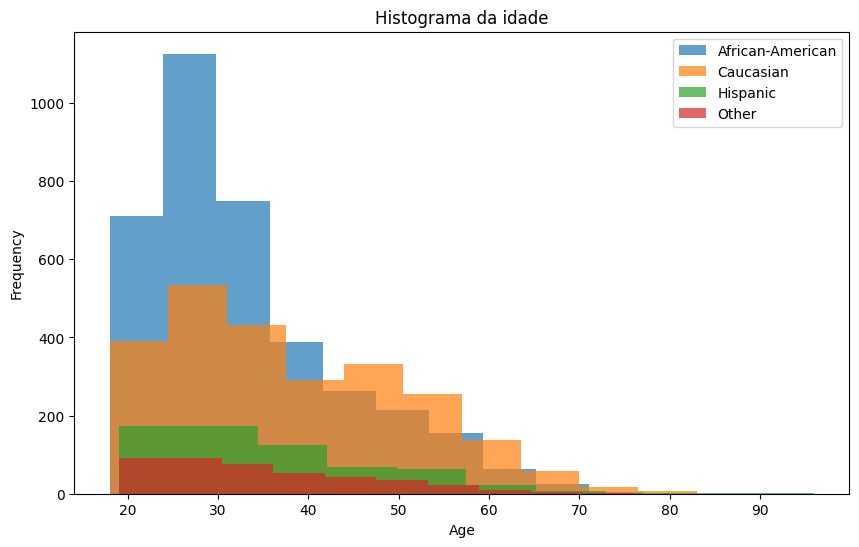

In [55]:
# A idade não é muito distorcida
compas_df.groupby('race')['age'].plot(figsize=(10,6),
                                      kind='hist',
                                      alpha=0.7,
                                      xlabel='Age',
                                      title='Histograma da idade')

# Adicionar legenda
plt.legend()

# Mostrar estatísticas descritivas
compas_df.groupby('race')['age'].describe()

Vamos voltar nossa atenção para `priors_count` e fazer a mesma impressão. Quando o fizermos, veremos alguns contrastes marcantes com a idade.

À primeira vista, pode parecer que o padrão de antecedentes para todas as raças é semelhante. As distribuições da contagem de antecedentes mostram uma inclinação à direita semelhante entre os grupos raciais. No entanto, por razões fora do controle de muitas pessoas, a mediana e a contagem média anterior dos afro-americanos são quase o dobro da dos outros grupos.

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,4.438853,5.579835,0.0,1.0,2.0,6.0,38.0
Caucasian,2454.0,2.586797,3.798803,0.0,0.0,1.0,3.0,36.0
Hispanic,637.0,2.252747,3.647673,0.0,0.0,1.0,2.0,26.0
Other,427.0,2.016393,3.695856,0.0,0.0,1.0,2.5,31.0


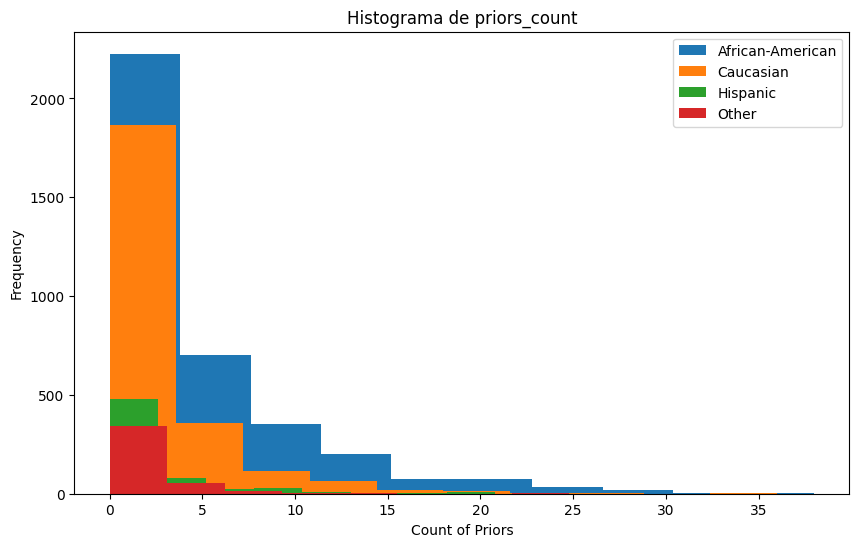

In [56]:
# priors_count é extremamente distorcida ao observar as diferenças em média/mediana/desvio padrão entre as categorias raciais
compas_df.groupby('race')['priors_count'].plot(
     figsize=(10, 6),
     kind='hist',
     xlabel='Count of Priors',
     title='Histograma de priors_count')

# Adicionar legenda
plt.legend()

# Mostrar estatísticas descritivas
compas_df.groupby('race')['priors_count'].describe()

Duas observações:

1. Os antecedentes afro-americanos são extremamente distorcidos para a direita, como evidenciado pela média ser superior ao dobro da mediana;
2. Os antecedentes afro-americanos são quase duas vezes mais elevados que os outros grupos raciais combinados devido a uma longa história de questões sistêmicas de justiça criminal.

O fato de `priors_count` estar tão correlacionado com a raça e ser distorcido de forma diferente para as diferentes categorias raciais é um grande problema, principalmente porque o modelo pode provavelmente perceber esse fato e tendenciar contra certas raças simplesmente olhando para a coluna `priors_count`. Para remediar isso, criaremos um transformador personalizado que modificará uma coluna aplicando a *transformação yeo-johnson* ao subconjunto de valores de cada categoria racial. Isto ajudará a eliminar o impacto díspar que esta coluna teria na justiça/equidade do nosso grupo.

Como pseudocódigo, seria parecido com:

```
Para cada rótulo do grupo:
         Obtenha o subconjunto de valores priors_count para esse grupo
         Aplique a transformação yeo-johnson ao subconjunto
         Modifique a coluna no lugar desse rótulo de grupo com os novos valores
```

Ao aplicar a transformação em cada subconjunto de valores em vez de aplicá-la à coluna como um todo, estamos forçando o conjunto de valores de cada grupo a ser normal com uma média de 0 e um desvio padrão de 1, tornando mais difícil para o modelo reconstruir um rótulo de grupo específico de um determinado valor `priors_count`.

Vamos construir um transformador `scikit-learn` personalizado para realizar esta operação.

**O que ele faz?**

1. Atua em uma coluna numérica (`col`), como `priors_count`.

2. Aplica uma transformação separada por grupo de uma variável sensível (label), como `race`.

3. Usa a técnica estatística **Yeo-Johnson** para normalizar os dados dentro de cada grupo.

Serve para mitigar **viés de tratamento desigual** — ou seja, para evitar que o modelo trate os grupos de forma diferente por causa da escala ou distribuição de certas variáveis, como `priors_count`.

In [57]:
# Mitigação de tratamento díspar por meio de Yeo-Johnson

# Importações
from sklearn.preprocessing import PowerTransformer        # transforma os dados para torná-los mais gaussianos
from sklearn.base import BaseEstimator, TransformerMixin  # classes base do `scikit-learn` para criar transformadores compatíveis com `Pipeline`

class NormalizeColumnByLabel(BaseEstimator, TransformerMixin):
    def __init__(self, col, label):
        self.col = col
        self.label = label
        self.transformers = {}

    # Ajuste um PowerTransformer para cada rótulo de grupo
    #
    # Para cada grupo único da variável sensível (ex: Caucasian, African-American):
    #
    # a. Cria um PowerTransformer (com yeo-johnson, que aceita 0 e negativos).
    # b. Treina esse transformador apenas com os dados do grupo atual.
    # c. Armazena no dicionário self.transformers.
    #
    # Assim, cada grupo tem sua própria transformação, ajustada à sua distribuição original.
    def fit(self, X, y=None):
        for group in X[self.label].unique():
            self.transformers[group] = PowerTransformer(
                method='yeo-johnson', standardize=True
            )
            self.transformers[group].fit(
                X.loc[X[self.label]==group][self.col].values.reshape(-1, 1)
            )
        return self

    # Ao transformar um novo Dataframe, usamos o método transform de nossos transformadores
    # já treinados e modificamos o dataframe no local

    # Cria uma cópia do DataFrame (C) para não modificar o original.
    # Para cada grupo:
    #
    # a. Aplica o transformador específico do grupo.
    # b. Substitui os valores transformados na coluna self.col apenas para aquele grupo.
    #
    #Isso padroniza os dados dentro de cada grupo, reduzindo diferenças estruturais injustas.
    def transform(self, X, y=None):
        C = X.copy()
        for group in X[self.label].unique():
            C.loc[X[self.label]==group, self.col] = self.transformers[group].transform(
                X.loc[X[self.label]==group][self.col].values.reshape(-1, 1)
            )
        return C

**Questão 1:** Por que isso é uma mitigação de viés?

**Questão 2:** Quais os benefícios da abordagem?

*Respostas:*

Com nosso novo transformador, vamos aplicá-lo aos nossos dados de treinamento para ver que nossas contagens de antecedentes foram modificadas para que cada rótulo de grupo tenha uma contagem média anterior de 0 e um desvio padrão de 1.

<ipython-input-57-6596a32e8bb6>:45: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.19091358 -1.19091358  1.26869417 ... -0.10439575  0.41212247
  0.73386571]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,2604.0,-8.868141e-17,1.000192,-1.394037,-0.549932,-0.092417,0.784661,2.276224
Caucasian,1700.0,1.097162e-16,1.000294,-1.190914,-1.190914,-0.104396,0.733866,2.293665
Hispanic,457.0,-9.911838e-17,1.001096,-1.124116,-1.124116,0.098333,0.620238,2.060623
Other,288.0,1.572816e-16,1.001741,-0.921525,-0.921525,-0.921525,0.878567,1.871600


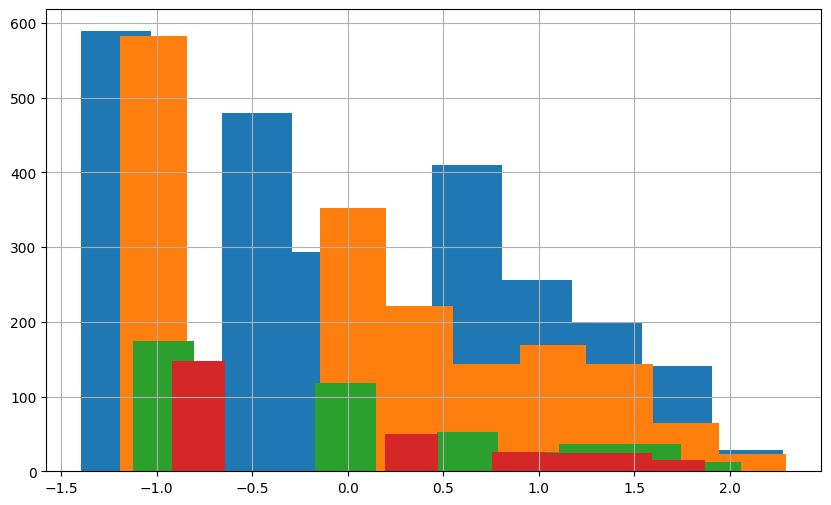

In [58]:
n = NormalizeColumnByLabel(col='priors_count', label='race')

X_train_normalized = n.fit_transform(X_train, y_train)

X_train_normalized.groupby('race')['priors_count'].hist(figsize=(10, 6))
X_train_normalized.groupby('race')['priors_count'].describe()

Observe o gráfico acima. Depois de aplicar a transformação *yeo-johnson* em cada subconjunto de subgrupos de contagens de antecedentes, as distribuições começam a parecer muito menos distorcidas e diferentes umas das outras. Isso tornará difícil para o modelo reconstruir a raça a partir desse atributo.

 Nosso primeiro modelo com reconhecimento de preconceito:

In [59]:
# Adicionar nosso novo transformador antes de nosso pré-processador para corrigir
# o priors_count antes de fazer qualquer outra coisa
clf_tree_aware = Pipeline(steps=[
     ('normalize_priors', NormalizeColumnByLabel(col='priors_count', label='race')),
     ('preprocessor', preprocessor),
     ('classifier', classifier)
])

clf_tree_aware.fit(X_train, y_train)
aware_y_preds = clf_tree_aware.predict(X_test)

# Confira o desempenho do nosso modelo
exp_tree_aware = dx.Explainer(clf_tree_aware, X_test, y_test, label='Random Forest DIR', verbose=False)
mf_tree_aware = exp_tree_aware.model_fairness(protected=race_test, privileged = "Caucasian")

# o desempenho geral permanece praticamente inalterado
pd.concat([exp.model_performance().result for exp in [exp_tree, exp_tree_aware]])

# Investigue a mudança na perda de paridade
# Podemos ver uma pequena queda na perda de paridade
mf_tree.plot(objects=[mf_tree_aware], type='stacked')

<ipython-input-57-6596a32e8bb6>:45: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.19091358 -1.19091358  1.26869417 ... -0.10439575  0.41212247
  0.73386571]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

<ipython-input-57-6596a32e8bb6>:45: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.62023814  1.97137986  0.92428519  1.95253475 -1.12411644 -1.12411644
  0.62023814  1.72059699 -1.12411644  0.09833278 -1.12411644 -1.12411644
  0.09833278  0.62023814  0.92428519  1.72059699 -1.12411644  0.09833278
 -1.12411644 -1.12411644  0.09833278  1.12830757  0.62023814  0.62023814
 -1.12411644  0.92428519  0.09833278 -1.12411644  1.62019152  0.09833278
  0.09833278  0.92428519 -1.12411644  0.92428519 -1.12411644 -1.12411644
  1.97137986 -1.12411644  0.09833278  0.09833278  0.62023814 -

A barra superior representa a soma de nossas métricas de tendência para nosso modelo com reconhecimento de tendência, que está observando um pequeno aumento no desempenho do modelo (observado na tabela de métricas) em todas as métricas, exceto no *recall*, onde permanece inalterado. A barra inferior mostra o gráfico empilhado original sem preconceito que vimos anteriormente. No geral, nosso novo modelo sem preconceitos tem desempenho melhor em algumas métricas de aprendizado de máquina e mostra uma diminuição no preconceito com base em nosso gráfico de barras de perda de paridade. Estamos no caminho certo!

Nosso novo modelo com reconhecimento de preconceito com Remoção de Impacto Díspar está funcionando muito bem! Na verdade, podemos ver um pequeno aumento no desempenho do modelo e uma pequena diminuição na perda cumulativa de paridade.

##Extração de recursos - Aprendendo a implementação de representação justa usando AIF360

Até agora, não fizemos nada para resolver o desconhecimento de recursos sensíveis do nosso modelo. Em vez de remover completamente a raça, usaremos AI Fairness 360 (`aif360`), que é um kit de ferramentas de código aberto desenvolvido pela IBM para ajudar os cientistas de dados a obter acesso a técnicas de mitigação de viés de pré-processamento, processamento e pós-processamento para aplicar nossa primeira extração de recursos técnica chamada aprendizagem de representação justa (LFR - Learning Fair Representation). A ideia do LFR é mapear nossos dados X (entrada).

Para nosso caso de uso, tentaremos mapear nossas variáveis ​​categóricas (4/6 delas representando raça) em um novo espaço vetorial “mais justo” que preserve a paridade estatística e retenha o máximo de informações possível de nosso X original.

`Aif360` pode ser um pouco complicado de usar, pois força você a usar sua própria versão de um *dataframe* chamado `BinaryLabelDataset`. Abaixo está um transformador `scikit-learn` personalizado que irá:

1. Considere X, um DataFrame de valores binários que são criados a partir de nosso pré-processador categórico;
2. Converta o dataframe em um `BinaryLabelDataset`;
3. Instale o módulo LFR do pacote `aif360`;
4. Transforme qualquer novo conjunto de dados usando o LFR agora adequado para mapeá-lo em nossa nova representação justa.

In [60]:
# Instalar o pacote aif360
!pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 3.8 MB/s eta 0:00:00


Criar o transformador LFR personalizado:

In [61]:
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.datasets import BinaryLabelDataset

class LFRCustom(BaseEstimator, TransformerMixin):
    def __init__(self, col, protected_col, unprivileged_groups, privileged_groups):
        self.col = col
        self.protected_col = protected_col
        self.TR = None
        self.unprivileged_groups = unprivileged_groups
        self.privileged_groups = privileged_groups

    def fit(self, X, y=None):
        d = pd.DataFrame(X, columns=self.col)
        d['response'] = list(y)

        # Conversão de e para o objeto aif360 BinaryLabelDataset
        binary_df = BinaryLabelDataset(
            df=d,
            protected_attribute_names=self.protected_col,
            label_names=['response']
        )

        # Qualidade de reconstrução de entrada - Ax
        # Erro de predição de saída - Ay
        # Restrição de justiça - Az

        self.TR = LFR(unprivileged_groups=self.unprivileged_groups,
                 privileged_groups=self.privileged_groups, seed=0,
                 k=2, Ax=0.5, Ay=0.2, Az=0.2,  # B
                 verbose=1
                )
        self.TR.fit(binary_df, maxiter=5000, maxfun=5000)
        return self

    def transform(self, X, y=None):
        d = pd.DataFrame(X, columns=self.col)
        if y:
            d['response'] = list(y)
        else:
            d['response'] = False

        binary_df = BinaryLabelDataset(
            df=d,
            protected_attribute_names=self.protected_col,
            label_names=['response']
        )
        # Esses parâmetros podem ser encontrados no site do aif360 e foram descobertos por meio de pesquisa de grade offline (grid searching)
        return self.TR.transform(binary_df).convert_to_dataframe()[0].drop(['response'], axis=1)

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


Para usar nosso novo transformador, precisaremos modificar ligeiramente nosso *pipeline* e usar o objeto `FeatureUnion`.

Criar modelo com Remoção de Impacto Díspar e LFR:

In [62]:
# Isolar o pré-processador numérico e categórico para que possamos ajustar
# o LFR aos dados categóricos separadamente
categorical_preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features)
])

# No momento, o pacote aif360 pode suportar apenas um grupo com privilégios e um sem privilégios
# Diga ao aif360 que as linhas com um rótulo caucasiano de 1 são privilegiadas e
# as linhas com um rótulo caucasiano de 0 não são privilegiadas
privileged_groups = [{'Caucasian': 1}]
unprivileged_groups = [{'Caucasian': 0}]

lfr = LFRCustom(
    col=['African-American', 'Caucasian', 'Hispanic', 'Other', 'Male', 'M'],
    protected_col=sorted(X_train['race'].unique()) ,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

categorical_pipeline = Pipeline([
    ('transform', categorical_preprocessor),
    ('LFR', lfr),
])

numerical_features = ["age", "priors_count"]
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

# Isolar o pré-processador numérico e categórico para que possamos ajustar
# o LFR aos dados categóricos separadamente
numerical_preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_features)
])

# Usar FeatureUnion para combinar nossos dados categóricos e nossos dados numéricos
preprocessor = FeatureUnion([
    ('numerical_preprocessor', numerical_preprocessor),
    ('categorical_pipeline', categorical_pipeline)
])

# Nosso novo pipeline removerá impactos/tratamentos díspares via yeo-johnson e
# aplicará LFR aos nossos dados categóricos para lidar com o desconhecimento do modelo
clf_tree_more_aware = Pipeline(steps=[
    ('normalize_priors', NormalizeColumnByLabel(col='priors_count', label='race')),
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

clf_tree_more_aware.fit(X_train, y_train)

more_aware_y_preds = clf_tree_more_aware.predict(X_test)

<ipython-input-57-6596a32e8bb6>:45: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.19091358 -1.19091358  1.26869417 ... -0.10439575  0.41212247
  0.73386571]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



step: 0, loss: 0.5113461179394596, L_x: 0.6910353031396581,  L_y: 0.750554787675951,  L_z: 0.07858754417220154
step: 250, loss: 0.263805662174865, L_x: 0.2544469519878086,  L_y: 0.6821786577239939,  L_z: 0.0007322731808096228
step: 500, loss: 0.2626475436785378, L_x: 0.25239914407146985,  L_y: 0.6822124084899083,  L_z: 2.744972410631541e-05
step: 750, loss: 0.26263395629851594, L_x: 0.25239115300050585,  L_y: 0.6821912720675263,  L_z: 6.269237887435164e-07
step: 1000, loss: 0.2626324669996723, L_x: 0.25238819168294885,  L_y: 0.6821915788955213,  L_z: 2.7689546805431675e-07
step: 1250, loss: 0.2626325136643599, L_x: 0.25238819343961916,  L_y: 0.6821915732614399,  L_z: 5.114613114975963e-07
step: 1500, loss: 0.2626324594750654, L_x: 0.25238819692635756,  L_y: 0.6821915689449343,  L_z: 2.3611449914695548e-07
step: 1750, loss: 0.26263926589265707, L_x: 0.25238546597736455,  L_y: 0.6821899694108766,  L_z: 4.269510899698736e-05


<ipython-input-57-6596a32e8bb6>:45: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.62023814  1.97137986  0.92428519  1.95253475 -1.12411644 -1.12411644
  0.62023814  1.72059699 -1.12411644  0.09833278 -1.12411644 -1.12411644
  0.09833278  0.62023814  0.92428519  1.72059699 -1.12411644  0.09833278
 -1.12411644 -1.12411644  0.09833278  1.12830757  0.62023814  0.62023814
 -1.12411644  0.92428519  0.09833278 -1.12411644  1.62019152  0.09833278
  0.09833278  0.92428519 -1.12411644  0.92428519 -1.12411644 -1.12411644
  1.97137986 -1.12411644  0.09833278  0.09833278  0.62023814 -1.12411644
  0.09833278 -1.12411644 -1.12411644  0.62023814  1.62019152 -1.12411644
  0.92428519 -1.12411644  1.76150988 -1.12411644 -1.12411644  1.72059699
  1.48234303  0.62023814  0.62023814  0.62023814 -1.12411644  0.92428519
  0.09833278  1.48234303  0.09833278  1.76150988  0.09833278  1.2769125
  0.09833278 -1.12411644  0.6202

Era muito código para simplesmente aplicar um módulo LFR ao nosso *dataframe*. Na verdade, a única razão pela qual isso foi tanto foi a necessidade de transformar nosso `Dataframe` do `pandas` no objeto de dados personalizado do `aif360` e vice-versa. Agora que ajustamos nosso modelo, vamos dar uma olhada final em sua imparcialidade.

In [63]:
exp_tree_more_aware = dx.Explainer(clf_tree_more_aware, X_test, y_test, label='Random Forest DIR + LFR', verbose=False)

mf_tree_more_aware = exp_tree_more_aware.model_fairness(protected=race_test, privileged="Caucasian")

pd.concat([exp.model_performance().result for exp in [exp_tree, exp_tree_aware, exp_tree_more_aware]])

<ipython-input-57-6596a32e8bb6>:45: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.62023814  1.97137986  0.92428519  1.95253475 -1.12411644 -1.12411644
  0.62023814  1.72059699 -1.12411644  0.09833278 -1.12411644 -1.12411644
  0.09833278  0.62023814  0.92428519  1.72059699 -1.12411644  0.09833278
 -1.12411644 -1.12411644  0.09833278  1.12830757  0.62023814  0.62023814
 -1.12411644  0.92428519  0.09833278 -1.12411644  1.62019152  0.09833278
  0.09833278  0.92428519 -1.12411644  0.92428519 -1.12411644 -1.12411644
  1.97137986 -1.12411644  0.09833278  0.09833278  0.62023814 -1.12411644
  0.09833278 -1.12411644 -1.12411644  0.62023814  1.62019152 -1.12411644
  0.92428519 -1.12411644  1.76150988 -1.12411644 -1.12411644  1.72059699
  1.48234303  0.62023814  0.62023814  0.62023814 -1.12411644  0.92428519
  0.09833278  1.48234303  0.09833278  1.76150988  0.09833278  1.2769125
  0.09833278 -1.12411644  0.6202

,recall,precision,f1,accuracy,auc
Random Forest Bias Unaware,0.560451,0.628736,0.592633,0.652656,0.693930
Random Forest DIR,0.560451,0.633835,0.594889,0.655889,0.694199
Random Forest DIR + LFR,0.558402,0.639671,0.596280,0.659122,0.693417


Nosso modelo final com reconhecimento de viés melhorou a exatidão/acurácia, f1 e a precisão e está observando apenas uma pequena queda no *recall* e na AUC. Isso é maravilhoso porque mostra que, ao reduzir o viés, conseguimos que nosso modelo de aprendizado de máquina tenha um desempenho melhor em métricas mais “clássicas”, como acurácia, ao mesmo tempo. Ganha-ganha!

Podemos ver que nosso modelo final com remoção de impacto díspar e LFR aplicado tem desempenho de modelo indiscutivelmente melhor do que nosso modelo de linha de base original.

Também queremos verificar a nossa perda acumulada de paridade para ter certeza de que estamos caminhando na direção certa.

Quando verificamos nosso gráfico, podemos ver que nossas métricas de justiça também estão diminuindo! Esta é uma ótima notícia. Nosso modelo não está sofrendo em termos de desempenho em relação ao nosso modelo básico e nosso modelo também está agindo de forma muito mais justa.

In [64]:
mf_tree.plot(objects=[mf_tree_aware, mf_tree_more_aware], type='stacked')

Observe o gráfico acima. Nosso modelo final com reconhecimento de preconceito que tem remoção de impacto díspar e LFR é o modelo mais justo até agora. Mais uma vez, tenha em mente que menor significa menos preconceito, o que geralmente é melhor para nós. Definitivamente, estamos fazendo alguns movimentos certos aqui para ver essa queda no viés e um aumento no desempenho do modelo depois de fazer algumas transformações bastante simples em nossos dados!

Vamos dar uma olhada em nossa verificação de imparcialidade do modelo `Dalex` uma última vez. Lembre-se de nosso modelo inconsciente, temos 7 números fora de nosso intervalo de (0,8; 1,25) e tivemos viés detectado em 4/5 métricas.

In [65]:
mf_tree_more_aware.fairness_check() # 4/15

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.626829  1.058268  1.198953  1.538095  1.712329
Hispanic          1.075610  1.102362  0.965096  0.828571  0.893836
Other             0.914634  0.996850  0.806283  1.100000  0.962329


Viés detectado em **3** métricas: TPR, FPR, STP
  
**Conclusão**: seu modelo **não é justo** porque **2** ou mais critérios excederam os limites aceitáveis definidos pelo *epsilon*.
  
Proporções de métricas, com base em 'Caucasiano'. O parâmetro *épsilon* foi definido como 0,8 e, portanto, as métricas devem estar dentro de (0,8, 1,25)

| Etnia           | TPR      | ACC      | PPV      | FPR      | STP      |
|-----------------|----------|----------|----------|----------|----------|
| Afro-americano  | **1,626829** | 1,058268 | 1,198953 | **1,538095** | **1,712329** |
| Hispânico       | 1,075610 | 1,102362 | 0,965096 | 0,285710 | 0,893836 |
| Outros          | 0,914634 | 0,996850 | 0,806283 | 1,100000 | 0,962329 |


Agora temos apenas 3 métricas fora do nosso intervalo, em oposição às 7 anteriores, e o viés agora só está sendo detectado em 3 métricas, em vez de 4. No geral, nosso trabalho pareceu melhorar ligeiramente o desempenho do nosso modelo e reduziu nossa perda de paridade acumulada simultaneamente.

Trabalhamos muito com esses dados, mas **estaríamos confortáveis em submeter esse modelo para ser considerado um preditor de reincidência preciso e justo?** ***Absolutamente não!*** Nosso trabalho nesta série de exercícios mal arranha a superfície do preconceito e da consciência de justiça e se concentra apenas em algumas técnicas de pré-processamento. Nem sequer começamos a discutir em profundidade as outras formas de mitigação de preconceitos disponíveis.

Resumo

* A justiça (*fairness*) do modelo é tão importante, senão a mais importante, do que apenas o desempenho do modelo;
* Existem várias maneiras de definir justiça em nosso modelo, cada uma com prós e contras;
* O puro desconhecimento de um modelo geralmente não é suficiente, dados os fatores correlacionados em nossos dados;
* Paridade estatística e probabilidades equalizadas são duas definições comuns de justiça, mas às vezes podem se contradizer;
* Podemos mitigar o preconceito antes, durante e depois do treinamento de um modelo;
* A remoção de impactos díspares e o aprendizado da representação justa ajudaram nosso modelo a se tornar mais justo e também levaram a um pequeno aumento no desempenho do modelo;
* O pré-processamento por si só não é suficiente para mitigar o viés. Também teríamos que trabalhar em métodos de processamento e pós-processamento para minimizar ainda mais nosso preconceito.

Fim da parte 3.

### REFERÊNCIAS

LACERDA, T. **Transformação de dados com Yeo-Johnson no Python**: como e por quê. Disponível em: https://medium.com/@tiago.beltrao.lacerda/transforma%C3%A7%C3%A3o-de-dados-com-yeo-johnson-no-python-como-e-por-qu%C3%AA-36cefcc022f5

OZDEMIR, S. Bias and fairness: Modeling recidivism. *In*: OZDEMIR, S. **Featuring engineering bootcamp**. Shelter Island: Manning Publications, 2022. p. 72-102.

OZDEMIR, S. **Bias and Fairness in Machine Learning, Part 1: introducing our dataset and the problem**. Disponível em: https://blog.devgenius.io/bias-and-fairness-in-machine-learning-part-1-introducing-our-dataset-and-the-problem-24f5f15c4f23.

OZDEMIR, S. **Bias and Fairness in Machine Learning, Part 2: building a baseline model and features**. Disponível em: https://blog.devgenius.io/bias-and-fairness-in-machine-learning-part-2-building-a-baseline-model-and-features-358d13b39f1a.

OZDEMIR, S. **Bias and Fairness in Machine Learning, Part 3: building a bias-aware model**. Disponível em: https://blog.devgenius.io/bias-and-fairness-in-machine-learning-part-3-building-a-bias-aware-model-1ecc04598a46.